In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
import seaborn as sns
from scipy.stats import norm
# Set the seaborn style for plotting
sns.set_theme(style="whitegrid")
# Set the seed to get the same results each time
np.random.seed(49)

In [70]:
numStars = 10000          # Total number of stars
gridSize = 400            # Box side length in pc (1 unit = 1 pc)
halfBox = gridSize / 2    # Half the size (box centered on the Sun)

meanMagnitude = 4.64      # Mean absolute magnitude for G stars
sigmaMagnitude = 0.6      # Standard deviation in absolute magnitude
apparentMagLimit = 9.0    # Limiting apparent magnitude for the survey
parallaxLimit = 0.01      # Parallax limit in arcsec (equivalent to d < 100 pc)

In [71]:
# Generate the star population locations
x = np.random.uniform(-halfBox, halfBox, numStars)
y = np.random.uniform(-halfBox, halfBox, numStars)
z = np.random.uniform(-halfBox, halfBox, numStars)
# Calculate distance from the Sun at (0, 0, 0)
distance = np.sqrt(x**2 + y**2 + z**2)
# Assign absolute magnitudes drawn from a Gaussian distribution
absoluteMagnitude = np.random.normal(loc=meanMagnitude, scale=sigmaMagnitude, size=numStars)

In [72]:
# Compute apparent magnitudes using the distance modulus formula
# apparentMag = absoluteMag + 5*log10(distance) - 5, where distance is in parsec
# A small check to avoid log10(0) is included by ensuring d > 0.
with np.errstate(divide='ignore'):
    apparentMagnitude = absoluteMagnitude + 5 * np.log10(distance) - 5

# Compute parallaxes in arcsec (parallax = 1/distance if in parsecs)
parallax = 1 / distance

# Construct the observational sample
# Only stars with below the apparentMagnitude and above the parallax are visible to our instrument
observed = (apparentMagnitude <= apparentMagLimit) & (parallax > parallaxLimit)
x_obs = x[observed]
y_obs = y[observed]
z_obs = z[observed]

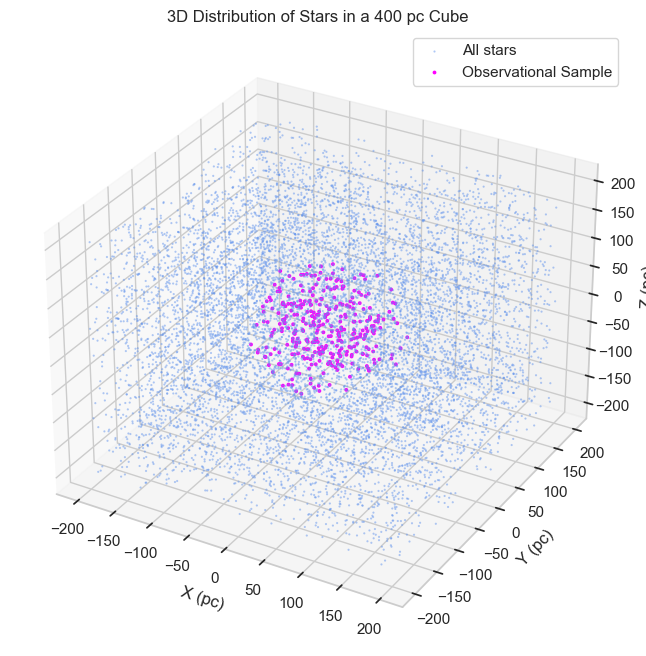

In [73]:
# Create a 3D scatter plot of all stars and highlight the observational sample
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot all stars in blue (with some transparency)
ax.scatter(x, y, z, s=0.3, color='cornflowerblue', alpha=0.5, label='All stars')

# Overlay the observational sample in red
ax.scatter(x_obs, y_obs, z_obs, s=3, color='magenta', alpha=1, label='Observational Sample')

# Label the axes and add a title
ax.set_xlabel("X (pc)")
ax.set_ylabel("Y (pc)")
ax.set_zlabel("Z (pc)")
ax.set_title("3D Distribution of Stars in a 400 pc Cube")
ax.legend()
plt.show()

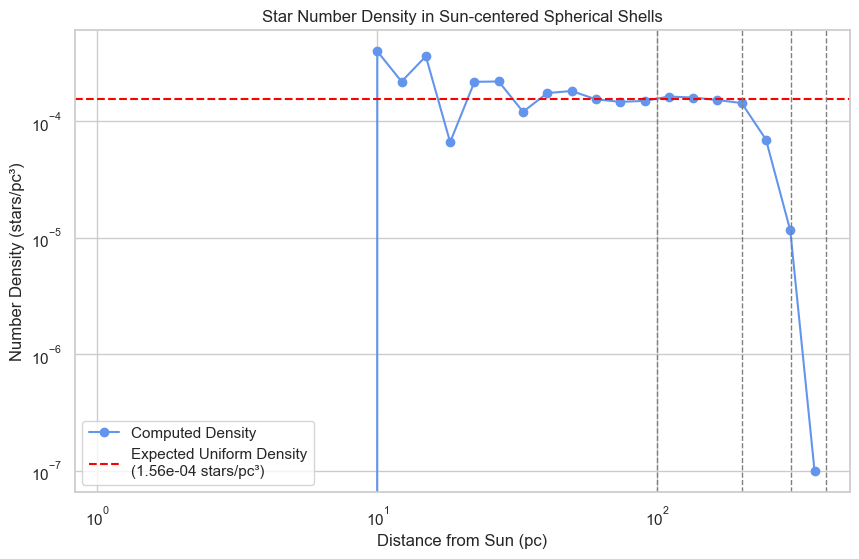

In [76]:
# Compute Number Density in Spherical Shells

# Use 20 shells spaced logarithmically from 1 pc to 400 pc
numOfShells = 30

# Create the edges of the shells in logrithmic space
edges = np.logspace(np.log10(1), np.log10(gridSize), numOfShells+1)

# Midpoints of the shells, used in plotting
midpoints = 0.5 * (edges[:-1] + edges[1:])

# Computed Values
densitiesInShell = []
starsInShell = []

for count in range(numOfShells):
    # Find stars whose distance is between the edges of the shell
    lowerEdge = edges[count]
    upperEdge = edges[count+1]
    # Compute the overlay mask
    included = (distance >= lowerEdge) & (distance < upperEdge)
    total = np.sum(included)
    starsInShell.append(total)
    
    # Compute the volume of the spherical shell, which is just the volume of the
    # upper sphere - lower sphere
    volume = (4/3)*np.pi*(upperEdge**3 - lowerEdge**3)
    densitiesInShell.append(total / volume)

# Expected uniform density (number of stars divided by cube volume)
expectedDensity = numStars / (gridSize**3)

#Plotting in a log-log plot
plt.figure(figsize=(10,6))
plt.loglog(midpoints, densitiesInShell, marker='o', linestyle='-', color='cornflowerblue', label='Computed Density')
plt.axhline(expectedDensity,
            color='red',
            linestyle='--', 
            label=f'Expected Uniform Density\n({expectedDensity:.2e} stars/pc³)')
# Plot vertical lines at 100, 200, 300, and 400 pc
for value in [100, 200, 300, 400]:
    plt.axvline(value, color='gray', linestyle='--', linewidth=1)
plt.xlabel("Distance from Sun (pc)")
plt.ylabel("Number Density (stars/pc³)")
plt.title("Star Number Density in Sun-centered Spherical Shells")
plt.legend()
plt.show()

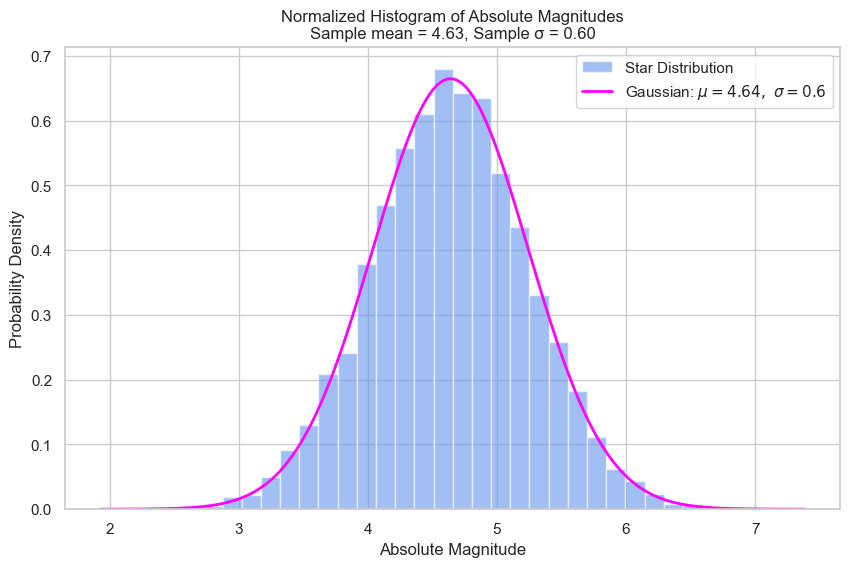

In [77]:
# Compute Sample Statistics
sampleMean = np.mean(absoluteMagnitude)
sampleStd = np.std(absoluteMagnitude)

# Plotting the Normalized Histogram
plt.figure(figsize=(10, 6))
bins = 30  # Number of histogram bins
# Plot the histogram with density=True so that the area is normalized to 1
plt.hist(absoluteMagnitude,
         bins=bins,
         density=True,
         alpha=0.6,
         color='cornflowerblue',
         label='Star Distribution')

# Overlay the Theoretical Gaussian
# Create an array of x values that spans the range of absolute magnitudes
theoretical = np.linspace(absoluteMagnitude.min() - 0.5, absoluteMagnitude.max() + 0.5, 200)
pdf = norm.pdf(theoretical, loc=meanMagnitude, scale=sigmaMagnitude)
plt.plot(theoretical, pdf, 'magenta', lw=2, label=r'Gaussian: $\mu=4.64,\ \sigma=0.6$')

# --- Labels and Title ---
plt.xlabel("Absolute Magnitude")
plt.ylabel("Probability Density")
plt.title(f"Normalized Histogram of Absolute Magnitudes\n"
          f"Sample mean = {sampleMean:.2f}, Sample σ = {sampleStd:.2f}")
plt.legend()
plt.show()

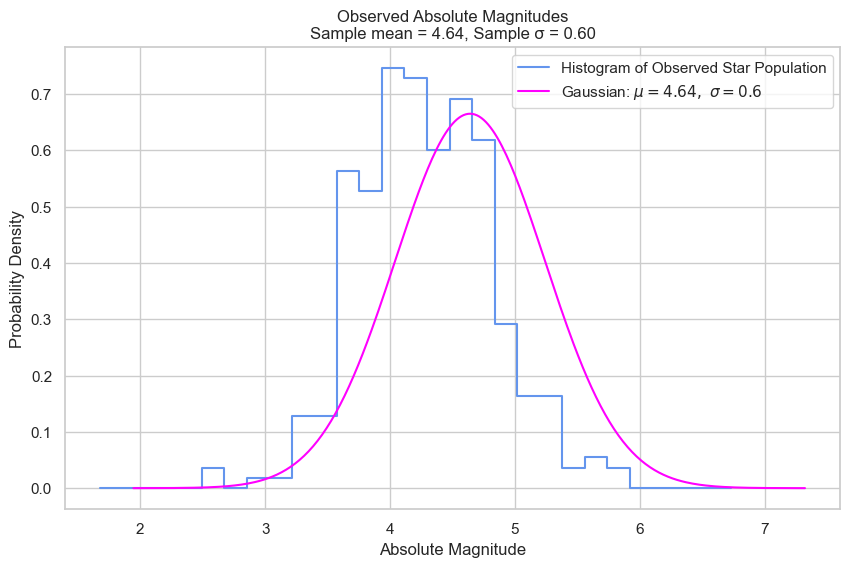

In [30]:
# Compare observed absolute magnitude vs. theoretical gaussian distribution
obsAbsMagnitude = absoluteMagnitude[observed]
plt.figure(figsize=(10, 6))
# Normalized histogram for the observational sample
bins = np.linspace(obsAbsMagnitude.min()-1, obsAbsMagnitude.max()+1, 30)
# np.histogram, when density is True, the result is the value of the pdf at the bin,
# normalized such that the integral over the range is 1
histogram, binEdges = np.histogram(obsAbsMagnitude, bins=bins, density=True)
binCenters =(binEdges[:-1] + binEdges[1:]) / 2
plt.plot(binCenters,
         histogram,
         drawstyle='steps-mid',
         color='cornflowerblue',
         label='Histogram of Observed Star Population')

# Overlay the Theoretical Gaussian
# Create an array of x values that spans the range of absolute magnitudes
theoretical = np.linspace(absoluteMagnitude.min() - 0.5, absoluteMagnitude.max() + 0.5, 300)
pdf = norm.pdf(theoretical, loc=meanMagnitude, scale=sigmaMagnitude)
plt.plot(theoretical, pdf, 'magenta', lw=1.5, label=r'Gaussian: $\mu=4.64,\ \sigma=0.6$')

plt.xlabel("Absolute Magnitude")
plt.ylabel("Probability Density")
plt.title(f"Observed Absolute Magnitudes\n"
          f"Sample mean = {sampleMean:.2f}, Sample σ = {sampleStd:.2f}")
plt.legend()
plt.show()

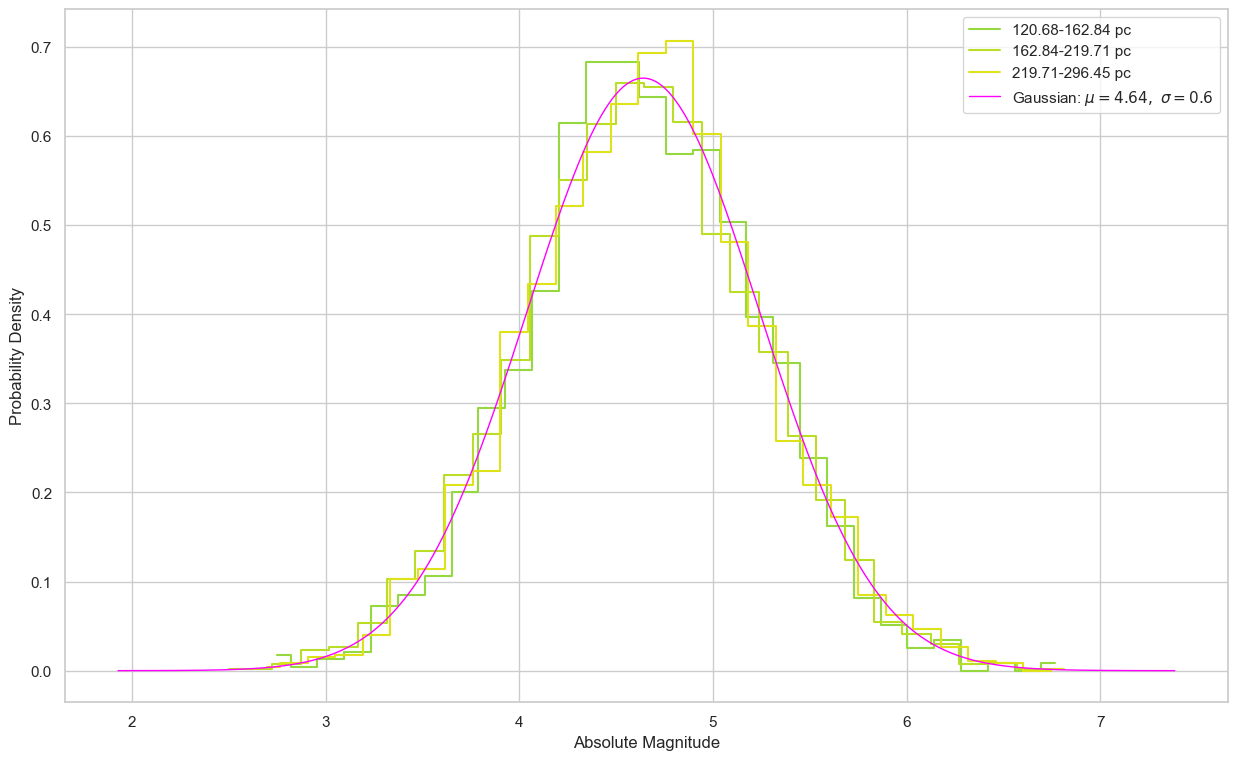

In [82]:
# Now lets do the same, for all the shells

# Setup colors for plotting each distribution
cmap = plt.get_cmap('viridis')
colors = [cmap(i / (numOfShells - 1)) for i in range(numOfShells)]

# Use 20 shells spaced logarithmically from 1 pc to 400 pc
numOfShells = 20
# Plot shells which satisfy min, max distance in pc
minDistance = 100
maxDistance = 300
# Whether to use log spacing for shells, linear otherwise
logSpacing = True

if logSpacing:
    shellEdges = np.logspace(np.log10(1), np.log10(gridSize), numOfShells+1)
else:
    shellEdges = np.linspace(0, gridSize, numOfShells+1)

plt.figure(figsize=(15, 9))
for count in range(numOfShells):
    lowerEdge = shellEdges[count]
    upperEdge = shellEdges[count+1]
    if (lowerEdge >= minDistance) and (upperEdge <= maxDistance):
        included = (distance >= lowerEdge) & (distance < upperEdge)
        shellAbsMagnitude = absoluteMagnitude[included]
        # Only continue if there are stars in the shell
        if len(shellAbsMagnitude) > 0:
            bins = np.linspace(shellAbsMagnitude.min()-1, shellAbsMagnitude.max()+1, 30)
            histogram, edges = np.histogram(shellAbsMagnitude, bins=30, density=True)
            centers =(edges[:-1] + edges[1:]) / 2
            plt.plot(centers,
                     histogram,
                     drawstyle='steps-mid',
                     color=colors[count],
                     label=f"{lowerEdge:.2f}-{upperEdge:.2f} pc")

# Overlay the Theoretical Gaussian
theoretical = np.linspace(absoluteMagnitude.min() - 0.5, absoluteMagnitude.max() + 0.5, 300)
pdf = norm.pdf(theoretical, loc=meanMagnitude, scale=sigmaMagnitude)
plt.plot(theoretical, pdf, 'magenta', lw=1, label=r'Gaussian: $\mu=4.64,\ \sigma=0.6$')


plt.xlabel("Absolute Magnitude")
plt.ylabel("Probability Density")
plt.legend()
plt.show()